# EDA for Potato Images



In [ ]:
pip install matplotlib
pip install pandas
pip install numpy
pip install seaborn
pip install tqdm
pip install albumentations

In [4]:
import os
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import pandas as pd
import numpy as np
import random
import cv2
from scipy.stats import kurtosis, skew
import seaborn as sns
from tqdm import tqdm

## Count the Number of Images in Each Folder


In [32]:
healthy_crop = "potato_vino/train/healthy_crop/"  
scurf = "potato_vino/train/Black_scurf_fungus/"
scab = "potato_vino/train/Common_scab_bacteria/" 
beetle = "potato_vino/train/Colorado_potato_beetle_insect/"
print("Healthy folder: " + str(len(os.listdir(healthy_crop))))
print("Scurf folder: " + str(len(os.listdir(scurf))))
print("Scab folder: " + str(len(os.listdir(scab))))
print("Beetle folder: " + str(len(os.listdir(beetle))))

Healthy folder: 80
Scurf folder: 46
Scab folder: 49
Beetle folder: 24


### Observation 
There is a significant imbalance between the categories. These will need to be addressed by taking the following measures:
* data augmentation techniques such as flipping, rotating, cropping, adjusting brightness and contrast, and adding noise.
* SMOTE (Synthetic Minority Over-sampling Technique), to create synthetic samples for the minority classes.
* OR Adjust class weights in the loss function during training to give more importance to the minority classes.


In [7]:
# Initialize list for the folders
folders = [healthy_crop, scurf, scab, beetle]

## Display sample images

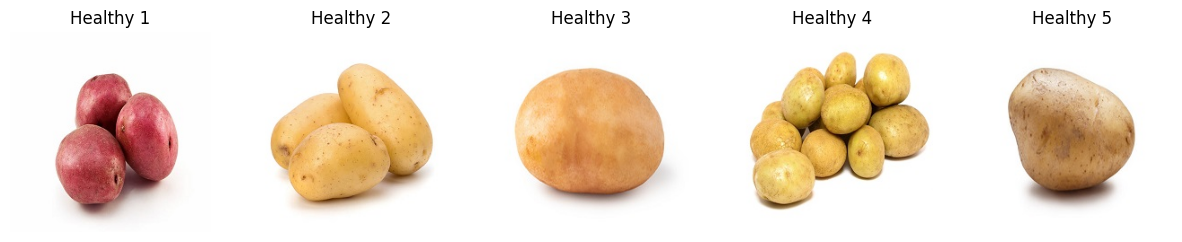

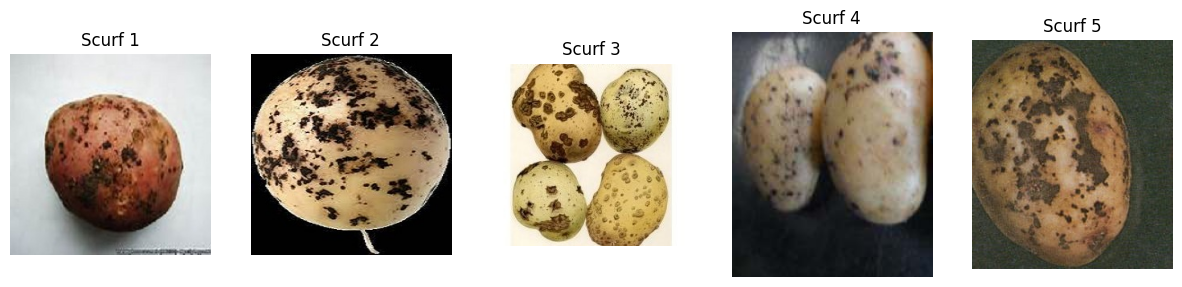

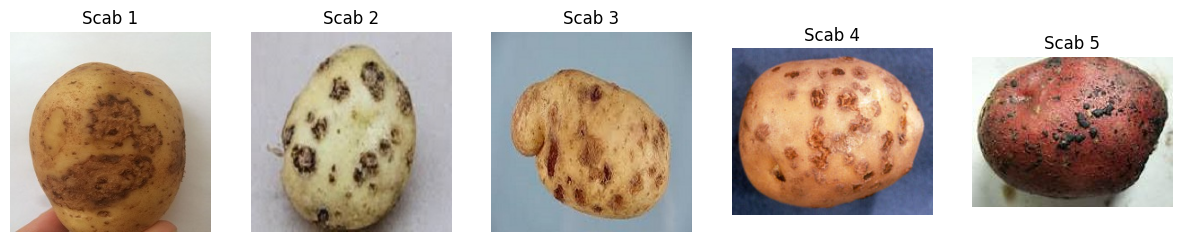

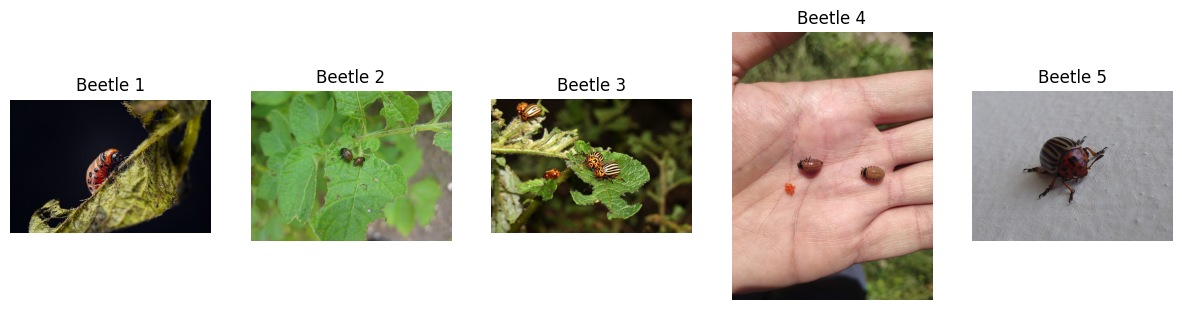

In [8]:
def display_sample_images(folder, title, num_images=5):
    image_files = os.listdir(folder)
    random_files = random.sample(image_files, num_images)
    
    plt.figure(figsize=(15, 5))
    for i, file in enumerate(random_files):
        img = cv2.imread(os.path.join(folder, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.show()

folders = [
    (healthy_crop, "Healthy"),
    (scurf, "Scurf"),
    (scab, "Scab"),
    (beetle, "Beetle")
]

for folder, title in folders:
    display_sample_images(folder, title)

## Check Image Dimensions


In [9]:
def check_image_dimensions(folder):
    dimensions = []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        image = cv2.imread(img_path)
        if image is not None:
            dimensions.append(image.shape[:2])  # (height, width)
    
    return np.array(dimensions)

# Collect image dimensions for each category
folder_dimensions = {
    "Healthy": check_image_dimensions(healthy_crop),
    "Scurf": check_image_dimensions(scurf),
    "Scab": check_image_dimensions(scab),
    "Beetle": check_image_dimensions(beetle)
}

## Display Summary Statistics

In [10]:
def display_summary_statistics(dimensions, category):
    heights = dimensions[:, 0]
    widths = dimensions[:, 1]
    
    summary_stats = {
        'Category': category,
        'Mean Height': np.mean(heights),
        'Mean Width': np.mean(widths),
        'Median Height': np.median(heights),
        'Median Width': np.median(widths),
        'Min Height': np.min(heights),
        'Min Width': np.min(widths),
        'Max Height': np.max(heights),
        'Max Width': np.max(widths)
    }
    
    return summary_stats

summary_statistics = []

for category, dimensions in folder_dimensions.items():
    stats = display_summary_statistics(dimensions, category)
    summary_statistics.append(stats)

# Convert to DataFrame for better readability
summary_df = pd.DataFrame(summary_statistics)
print(summary_df)


  Category  Mean Height  Mean Width  Median Height  Median Width  Min Height  \
0  Healthy   285.138614  310.495050          224.0         224.0         224   
1    Scurf   255.724138  274.344828          224.0         224.0         157   
2     Scab   244.370968  270.516129          224.0         224.0         123   
3   Beetle   492.766667  639.966667          480.0         640.0         340   

   Min Width  Max Height  Max Width  
0        224         821        640  
1        171         597        900  
2        182         674       1024  
3        639         855        640  


## Visualize the distribution of image dimensions using histograms

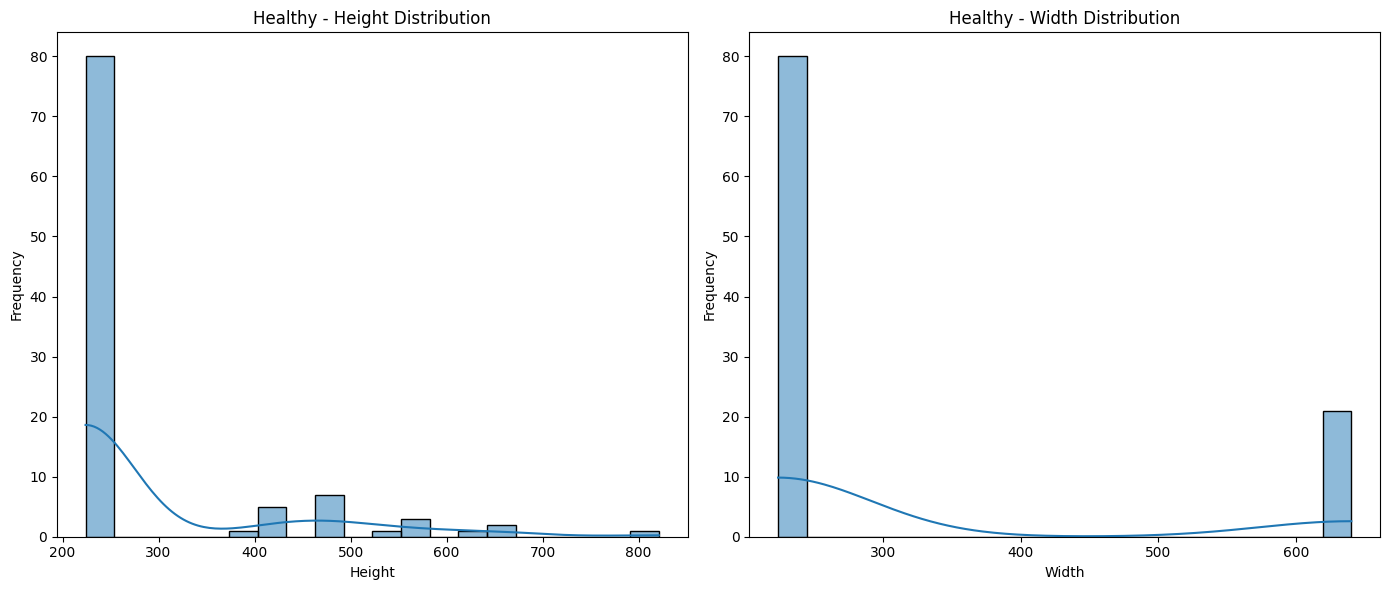

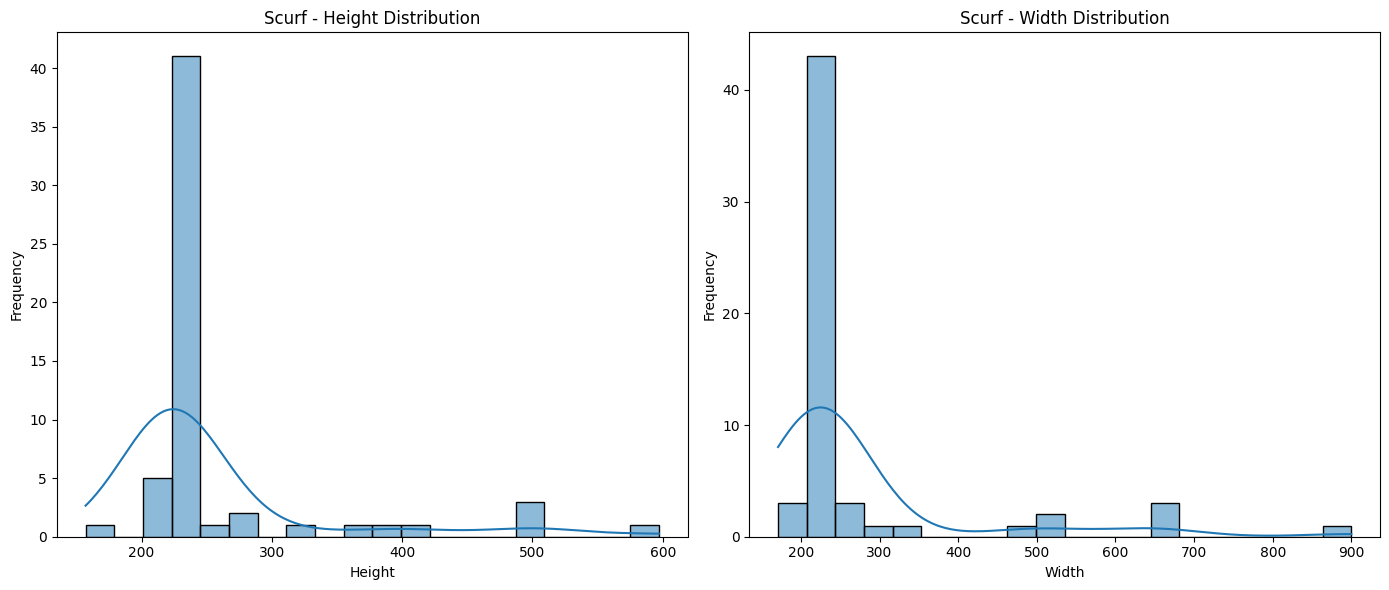

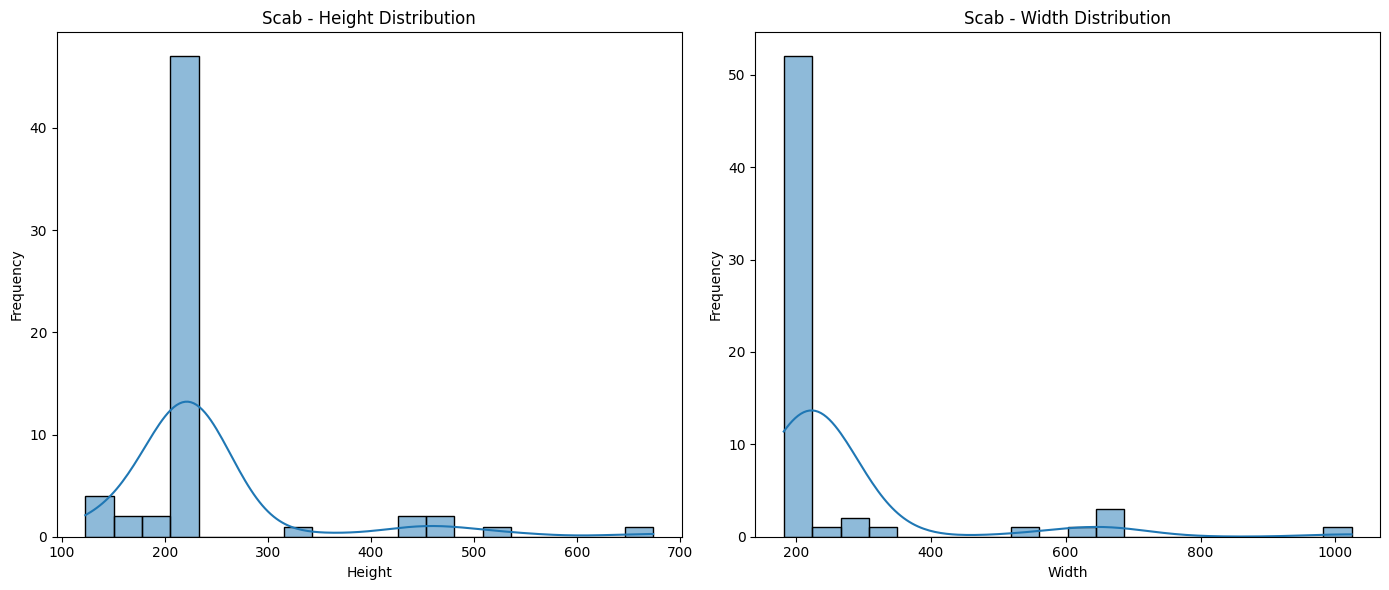

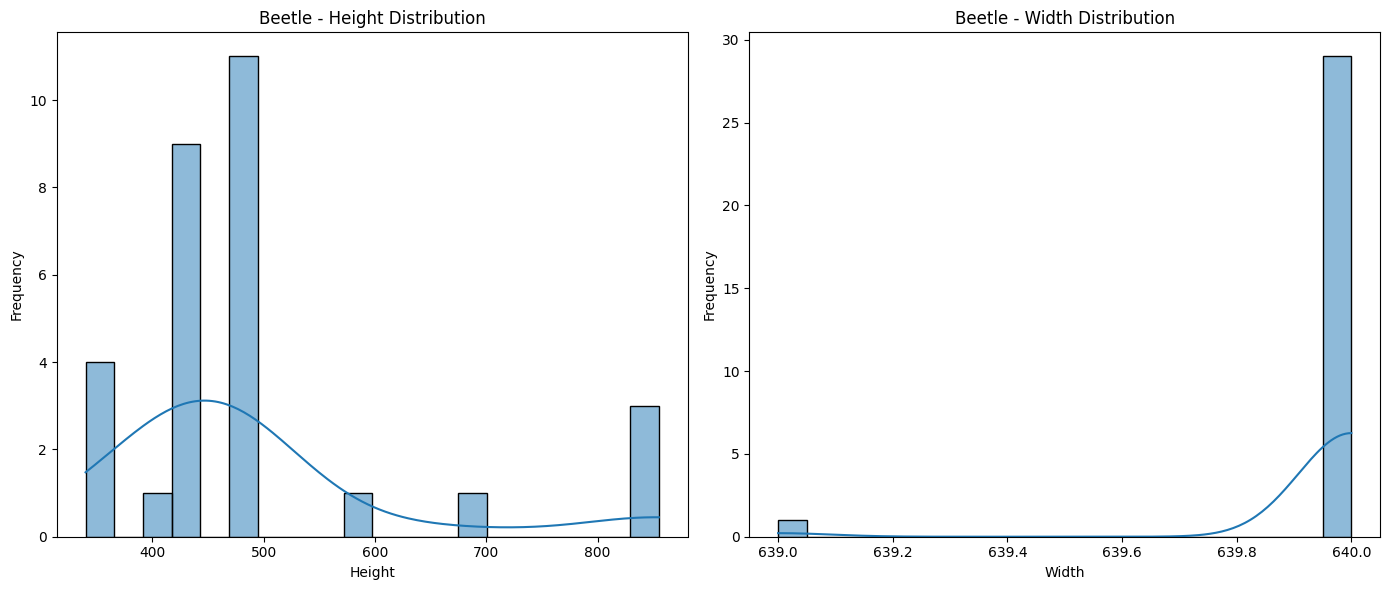

In [11]:
def plot_dimensions_distribution(dimensions, category):
    heights = dimensions[:, 0]
    widths = dimensions[:, 1]
    
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(heights, kde=True, bins=20)
    plt.title(f'{category} - Height Distribution')
    plt.xlabel('Height')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    sns.histplot(widths, kde=True, bins=20)
    plt.title(f'{category} - Width Distribution')
    plt.xlabel('Width')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Plot dimensions distribution for each category
for category, dimensions in folder_dimensions.items():
    plot_dimensions_distribution(dimensions, category)


### Observations - Dimensions
* The dimensions of the images vary significantly between categories. For instance, Beetle images have larger dimensions compared to Healthy, Scurf, and Scab images.
* There are some images with smaller dimensions (min values), which might indicate lower-resolution images or cropped images.
* The median dimensions for Healthy, Scurf, and Scab images are consistent (224x224). However, Beetle images have a median dimension of 480x640, indicating a different typical size for this category.

Actions that can be taken
* All images could be resized to a common dimension, such as 256x256 or 224x224.
* Remove outliers with extreme dimensions


## Detect outliers by size data

In [24]:
# Function to check image dimensions
def check_image_dimensions(folder):
    dimensions = []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        image = cv2.imread(img_path)
        #print(img_name)
        if image is not None:
            dimensions.append((img_name, image.shape[:2]))  # (file_name, (height, width))

    #print (dimensions)
    return dimensions


# Function to detect outliers using MAD
def detect_outliers_mad(dimensions):
    heights = []
    widths = []
    for dim in dimensions:
        if isinstance(dim[1], tuple) and len(dim[1]) == 2:
            heights.append(dim[1][0])
            widths.append(dim[1][1])
    
    if len(heights) == 0 or len(widths) == 0:
        print("No valid dimensions found.")
        return []
    
    heights = np.array(heights)
    widths = np.array(widths)
    
    height_median = np.median(heights)
    width_median = np.median(widths)
    
    height_mad = np.median(np.abs(heights - height_median))
    width_mad = np.median(np.abs(widths - width_median))
    
    # Add a small constant to avoid division by zero
    height_mad = height_mad if height_mad != 0 else 1e-6
    width_mad = width_mad if width_mad != 0 else 1e-6
    
    height_z_scores = 0.6745 * (heights - height_median) / height_mad
    width_z_scores = 0.6745 * (widths - width_median) / width_mad
    
    height_outliers = np.abs(height_z_scores) > 3.5
    width_outliers = np.abs(width_z_scores) > 3.5
    
    outliers = height_outliers | width_outliers
    
    return [dimensions[i][0] for i in range(len(dimensions)) if outliers[i]]



# Function to display outlier results
def display_outlier_results(folder, category):
    dimensions = check_image_dimensions(folder)
    outliers = detect_outliers_mad(dimensions)
    
    if len(outliers) == 0:
        print(f"{category} - No outliers detected or insufficient data.")
        return
    
    total_images = len(dimensions)
    num_outliers = len(outliers)
    percent_outliers = (num_outliers / total_images) * 100 if total_images > 0 else 0
    
    print(f"{category} - Number of outliers: {num_outliers}")
    print(f"{category} - Percentage of outliers: {percent_outliers:.2f}%")
    

# Define folders
folders = [
    ("potato_vino/train/healthy_crop/", "Healthy"),
    ("potato_vino/train/Black_scurf_fungus/", "Scurf"),
    ("potato_vino/train/Common_scab_bacteria/", "Scab"),
    ("potato_vino/train/Colorado_potato_beetle_insect/", "Beetle")
]

# Display outlier results for each folder
for folder, category in folders:
    display_outlier_results(folder, category)



Healthy - Number of outliers: 21
Healthy - Percentage of outliers: 20.79%
Scurf - Number of outliers: 21
Scurf - Percentage of outliers: 36.21%
Scab - Number of outliers: 15
Scab - Percentage of outliers: 24.19%
Beetle - Number of outliers: 4
Beetle - Percentage of outliers: 13.33%


## Observation - Image Size
Given the number of image samples is small to begin with, removing outlier images would reduce the number of images by a significant %. So better to resize all images

# Resize images to the same uniform size

In [33]:
import os
import cv2
from tqdm import tqdm

# Function to resize images
def resize_images(input_dir, output_dir, size=(256, 256)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for img_name in tqdm(os.listdir(input_dir)):
        img_path = os.path.join(input_dir, img_name)
        image = cv2.imread(img_path)
        if image is not None:
            resized_image = cv2.resize(image, size)
            cv2.imwrite(os.path.join(output_dir, img_name), resized_image)

# Define input and output folders for resizing images
resize_folders = [
    ("potato_vino/train/healthy_crop/", "potato_vino/train/healthy_crop_resized/"),
    ("potato_vino/train/Black_scurf_fungus/", "potato_vino/train/Black_scurf_fungus_resized/"),
    ("potato_vino/train/Common_scab_bacteria/", "potato_vino/train/Common_scab_bacteria_resized/"),
    ("potato_vino/train/Colorado_potato_beetle_insect/", "potato_vino/train/Colorado_potato_beetle_insect_resized/")
]

# Resize images in each folder
for input_dir, output_dir in resize_folders:
    resize_images(input_dir, output_dir)



100%|███████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 169.16it/s]


In [35]:


# Function to calculate mean and std of RGB values
def calculate_rgb_statistics(folder):
    rgb_means = []
    rgb_stds = []
    for img_name in tqdm(os.listdir(folder)):
        img_path = os.path.join(folder, img_name)
        image = cv2.imread(img_path)
        if image is not None:
            # Convert image from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Calculate mean and std for each channel
            mean = np.mean(image, axis=(0, 1))
            std = np.std(image, axis=(0, 1))
            rgb_means.append(mean)
            rgb_stds.append(std)
    return np.array(rgb_means), np.array(rgb_stds)

# Define folders
folders = [
    ("potato_vino/train/healthy_crop/", "Healthy"),
    ("potato_vino/train/Black_scurf_fungus/", "Scurf"),
    ("potato_vino/train/Common_scab_bacteria/", "Scab"),
    ("potato_vino/train/Colorado_potato_beetle_insect/", "Beetle")]

# Collect RGB statistics for each category
rgb_statistics = {}
for folder, category in folders:
    means, stds = calculate_rgb_statistics(folder)
    rgb_statistics[category] = {'means': means, 'stds': stds}


100%|████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.93it/s]


In [36]:
def display_rgb_statistics(rgb_statistics):
    summary_stats = []
    for category, stats in rgb_statistics.items():
        mean_means = np.mean(stats['means'], axis=0)
        std_means = np.mean(stats['stds'], axis=0)
        summary_stats.append({
            'Category': category,
            'Mean R': mean_means[0],
            'Mean G': mean_means[1],
            'Mean B': mean_means[2],
            'Std R': std_means[0],
            'Std G': std_means[1],
            'Std B': std_means[2]
        })
    summary_df = pd.DataFrame(summary_stats)
    print(summary_df)

display_rgb_statistics(rgb_statistics)


  Category      Mean R      Mean G      Mean B      Std R      Std G  \
0  Healthy  214.355852  192.693796  164.359544  32.826115  46.798773   
1    Scurf  152.454153  132.945343  106.574239  56.611294  61.058221   
2     Scab  143.393124  121.750554  101.132634  60.230516  57.149774   
3   Beetle  124.879458  128.179951   90.667680  50.826694  48.835258   

       Std B  
0  68.952436  
1  64.683731  
2  55.000108  
3  43.489640  


### Observation - RGB   

#### Color Imbalance:
* The Healthy images are significantly brighter and more vibrant compared to the other categories, which may cause the model to be biased towards identifying these images more easily.
* Beetle images are the darkest, which might make it harder for the model to distinguish features if trained on RGB values alone.

#### Variability:
The variability in color (standard deviation) is highest in the Healthy category, which might make the model more robust in identifying various healthy images but could also introduce challenges in generalizing to other categories.

#### Recommendations to address the color imbalance and variability

   * Color Normalization:
        Normalize the color values across the dataset to ensure that the model does not get biased due to the brightness and color intensity differences. This can be done by standardizing the RGB values (mean subtraction and division by standard deviation).

   * Data Augmentation:
        Apply data augmentation techniques to increase the variability and robustness of the dataset, especially for darker images. Techniques such as brightness adjustment, contrast adjustment, and color jittering can be used.

   * Histogram Equalization:
        Apply histogram equalization to improve the contrast in darker images, which can help in highlighting features that may otherwise be hard to detect.

100%|████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 34.90it/s]


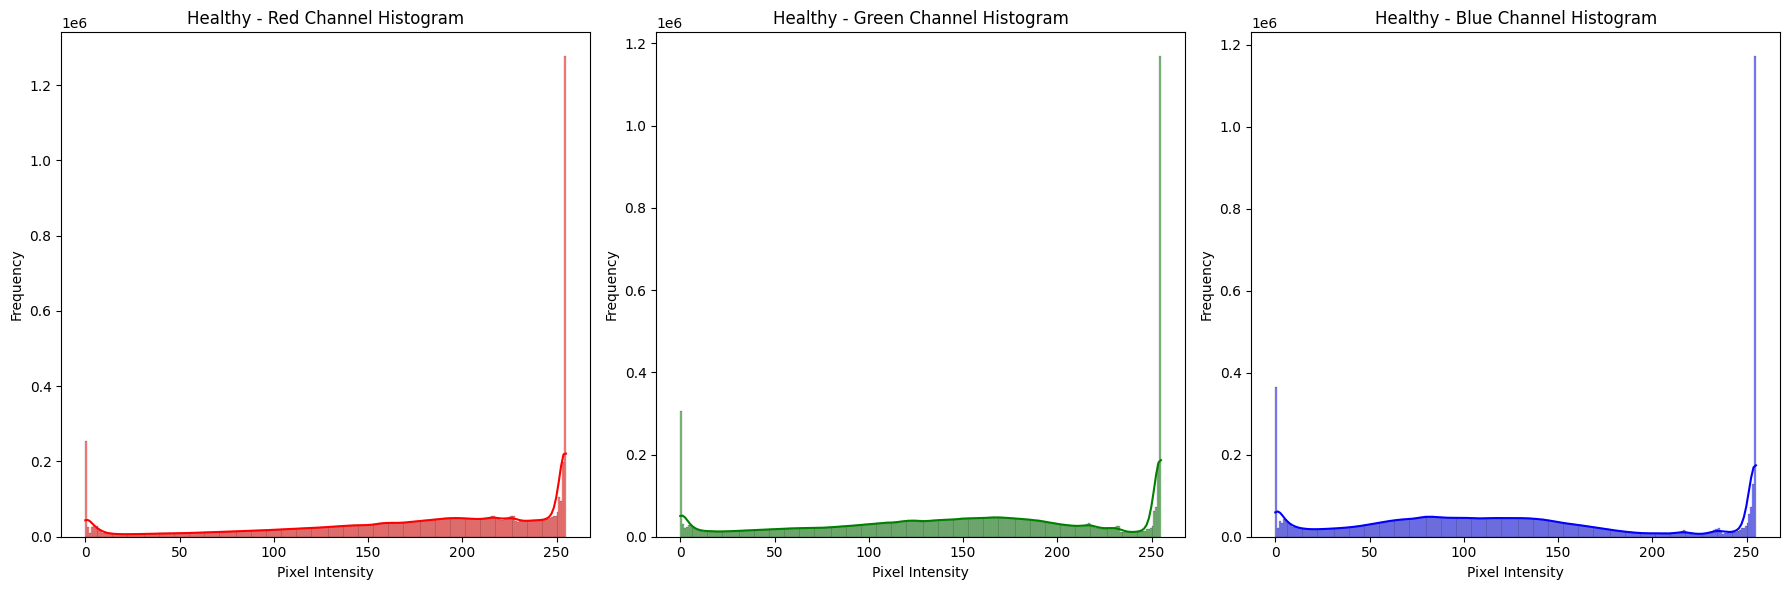

100%|████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 58.13it/s]


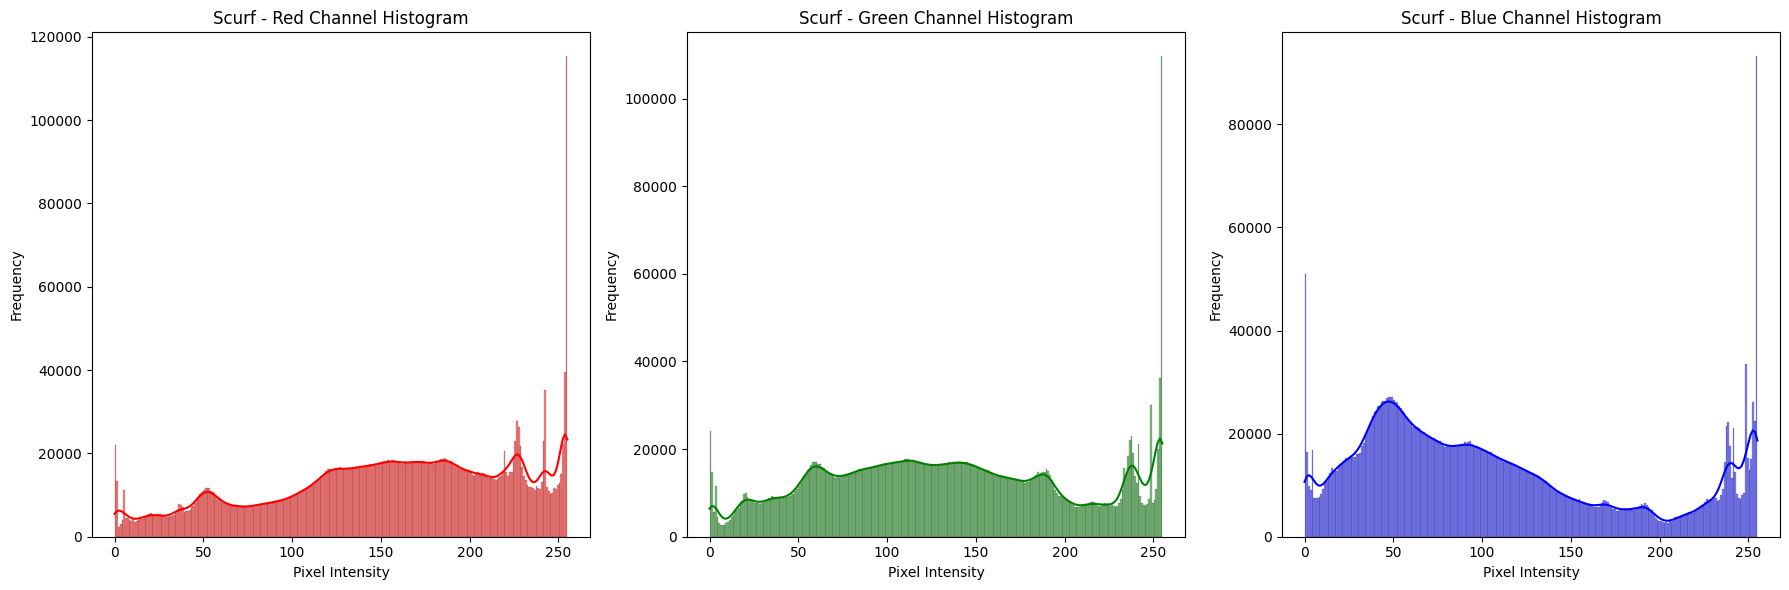

100%|████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 42.76it/s]


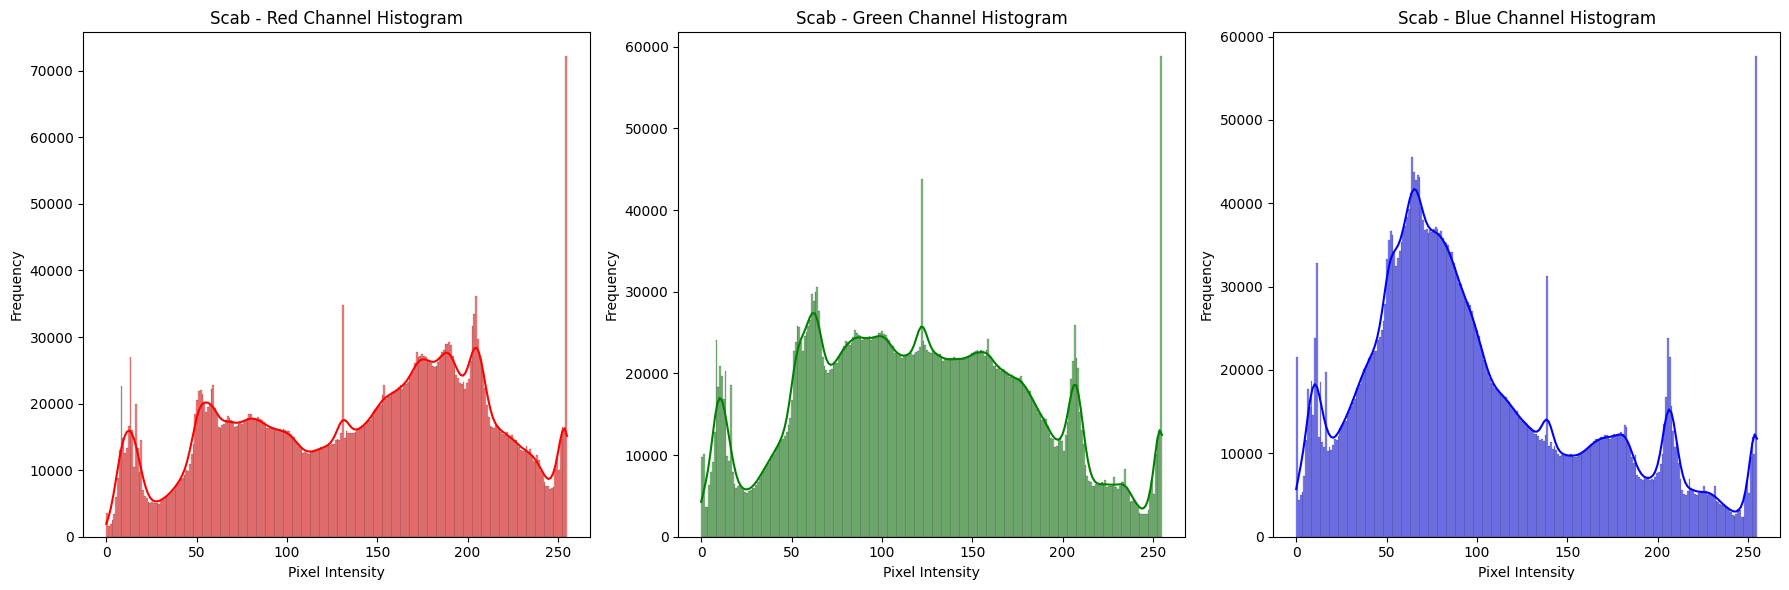

100%|████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.58it/s]


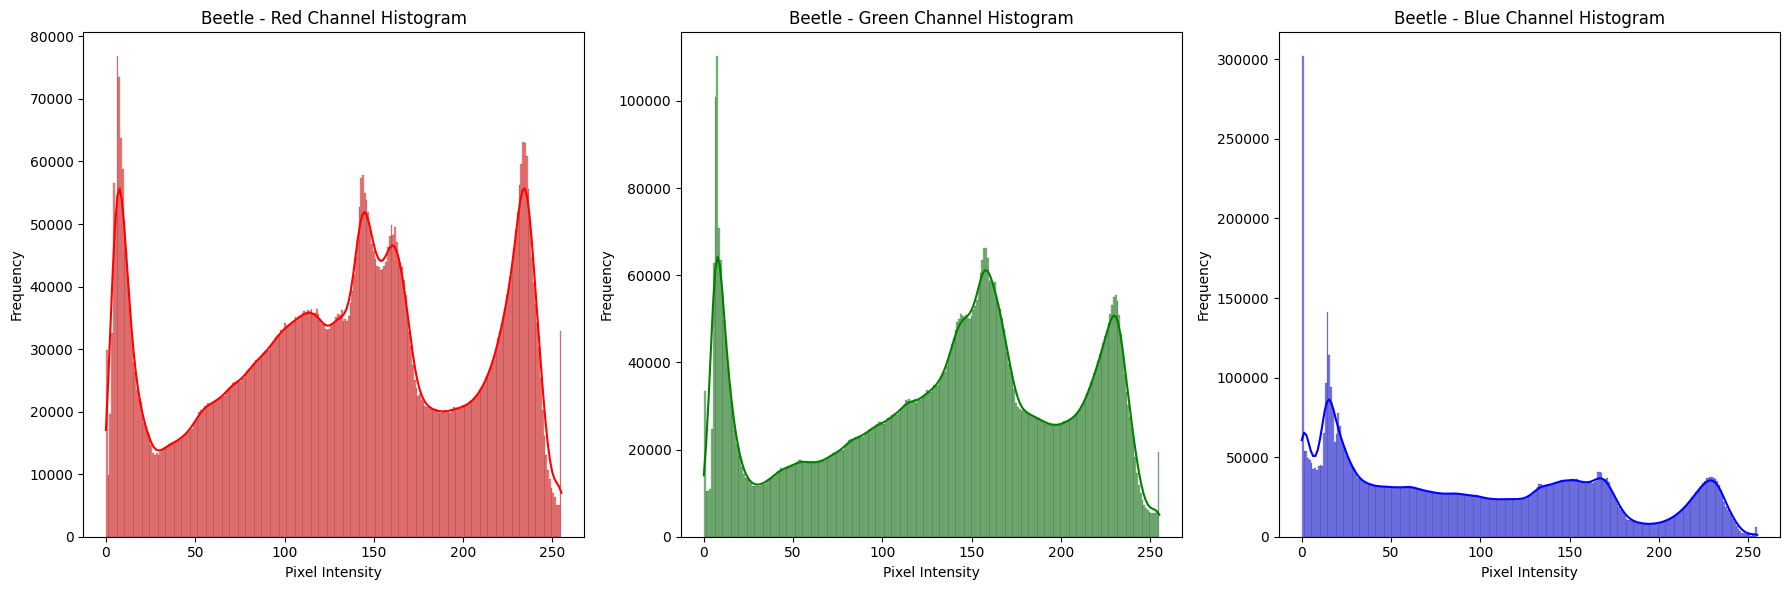

In [62]:
# Function to collect RGB statistics
def collect_rgb_statistics(folder):
    r_values = []
    g_values = []
    b_values = []
    for img_name in tqdm(os.listdir(folder)):
        img_path = os.path.join(folder, img_name)
        image = cv2.imread(img_path)
        if image is not None:
            # Convert image from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Flatten the image arrays and add to the lists
            r_values.extend(image[:, :, 0].flatten())
            g_values.extend(image[:, :, 1].flatten())
            b_values.extend(image[:, :, 2].flatten())
    return r_values, g_values, b_values


# Function to plot histograms of RGB values
def plot_rgb_histograms(r_values, g_values, b_values, category):
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    sns.histplot(r_values, bins=256, kde=True, color='red')
    plt.title(f'{category} - Red Channel Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    sns.histplot(g_values, bins=256, kde=True, color='green')
    plt.title(f'{category} - Green Channel Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 3)
    sns.histplot(b_values, bins=256, kde=True, color='blue')
    plt.title(f'{category} - Blue Channel Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

folders = [
    ("potato_vino/train/healthy_crop/", "Healthy"),
    ("potato_vino/train/Black_scurf_fungus/", "Scurf"),
    ("potato_vino/train/Common_scab_bacteria/", "Scab"),
    ("potato_vino/train/Colorado_potato_beetle_insect/", "Beetle")
]

# Collect RGB statistics and plot histograms for each folder
for folder, category in folders:
    r_values, g_values, b_values = collect_rgb_statistics(folder)
    plot_rgb_histograms(r_values, g_values, b_values, category)


## Check images for bluriness, plot and analyze distribution and detect outliers

100%|█████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 414.15it/s]


Healthy - Skewness: 3.60
Healthy - Kurtosis: 14.48
Healthy - Number of outliers: 5
Healthy - Percentage of outliers: 4.95%


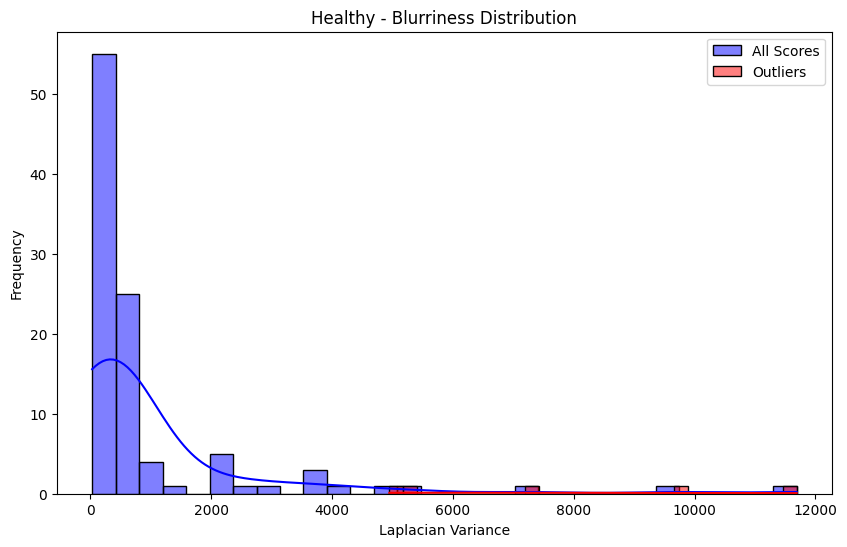

100%|███████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 362.85it/s]


Scurf - Skewness: 1.78
Scurf - Kurtosis: 3.30
Scurf - Number of outliers: 0
Scurf - Percentage of outliers: 0.00%


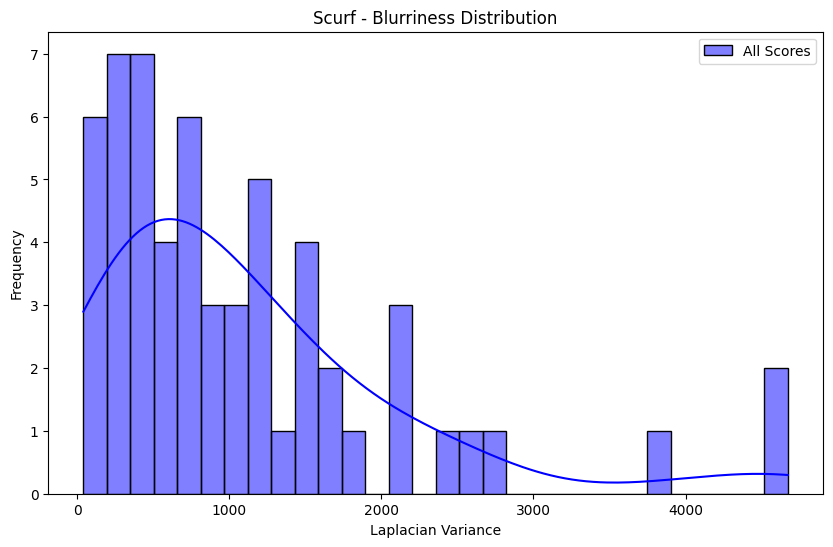

100%|███████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 421.01it/s]


Scab - Skewness: 1.76
Scab - Kurtosis: 3.16
Scab - Number of outliers: 0
Scab - Percentage of outliers: 0.00%


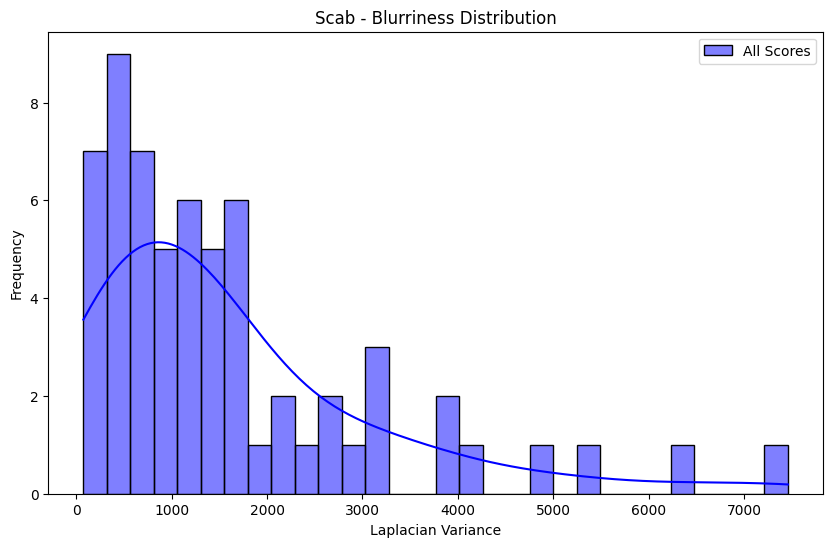

100%|███████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 151.11it/s]


Beetle - Skewness: 2.02
Beetle - Kurtosis: 3.75
Beetle - Number of outliers: 1
Beetle - Percentage of outliers: 3.33%


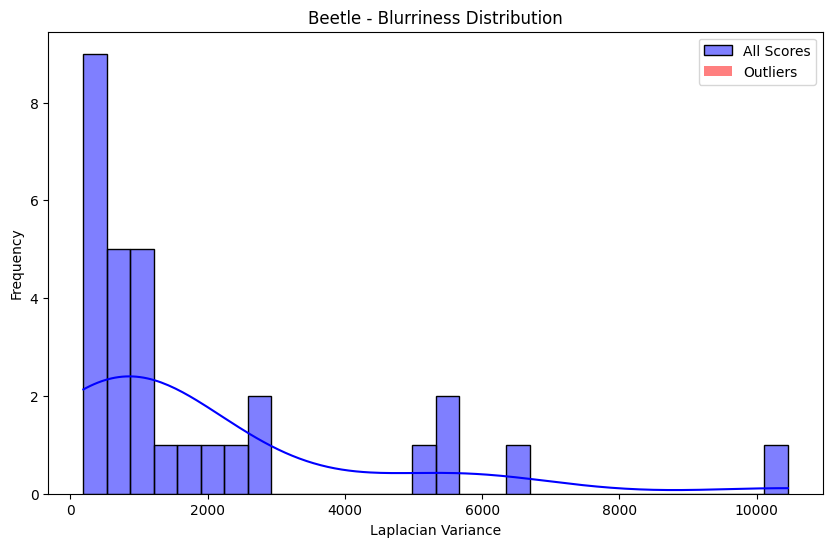

In [49]:
# Function to calculate the variance of the Laplacian (blurriness)
def calculate_blurriness(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    variance = cv2.Laplacian(gray, cv2.CV_64F).var()
    return variance

# Function to check blurriness of images in a folder
def check_blurriness(folder):
    blurriness_scores = []
    for img_name in tqdm(os.listdir(folder)):
        img_path = os.path.join(folder, img_name)
        image = cv2.imread(img_path)
        if image is not None:
            blurriness = calculate_blurriness(image)
            blurriness_scores.append((img_name, blurriness))
    return blurriness_scores

# Function to detect outliers using adjusted MAD
def detect_outliers_mad(scores):
    scores_array = np.array([score[1] for score in scores])
    median = np.median(scores_array)
    mad = np.median(np.abs(scores_array - median))
    mad = mad if mad != 0 else 1e-6  # To prevent division by zero
    
    # Adjust threshold based on skewness and kurtosis
    skewness = skew(scores_array)
    kurt = kurtosis(scores_array)
    threshold = 3.5 + 0.5 * (np.abs(skewness) + np.abs(kurt))
    
    modified_z_scores = 0.6745 * (scores_array - median) / mad
    outliers = np.abs(modified_z_scores) > threshold
    return outliers

# Function to analyze distribution and plot blurriness scores
def analyze_and_plot_blurriness(blurriness_scores, outliers, category):
    scores = [score[1] for score in blurriness_scores]
    outlier_scores = [score[1] for i, score in enumerate(blurriness_scores) if outliers[i]]
    
    skewness = skew(scores)
    kurt = kurtosis(scores)
    
    print(f"{category} - Skewness: {skewness:.2f}")
    print(f"{category} - Kurtosis: {kurt:.2f}")
    print(f"{category} - Number of outliers: {len(outlier_scores)}")
    print(f"{category} - Percentage of outliers: {(len(outlier_scores) / len(scores)) * 100:.2f}%")
    
    plt.figure(figsize=(10, 6))
    sns.histplot(scores, bins=30, kde=True, color='blue', label='All Scores')
    sns.histplot(outlier_scores, bins=30, kde=True, color='red', label='Outliers')
    plt.title(f'{category} - Blurriness Distribution')
    plt.xlabel('Laplacian Variance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


# Define input folders for blurriness analysis
folders = [
    ("potato_vino/healthy_crop/", "Healthy"),
    ("potato_vino/Black_scurf_fungus/", "Scurf"),
    ("potato_vino/Common_scab_bacteria/", "Scab"),
    ("potato_vino/Colorado_potato_beetle_insect/", "Beetle")
]

# Check blurriness, detect outliers, analyze distribution, and plot for each folder
for folder, category in folders:
    blurriness_scores = check_blurriness(folder)
    outliers = detect_outliers_mad(blurriness_scores)
    analyze_and_plot_blurriness(blurriness_scores, outliers, category)

### Observations - Blurriness
* Healthy: High positive skewness (3.60) and very heavy tails (kurtosis 14.48) indicate a significant number of images with low blurriness scores and a few with very high blurriness scores. 5 outliers (4.95%) suggest a moderate level of inconsistency in image blurriness.

* Scurf and Scab: Moderate positive skewness  and slightly heavy tails  suggest that most images have low blurriness scores with fewer extreme values. No outliers indicate high consistency in image blurriness.

* Beetle: Positive skewness (2.02) and slightly heavy tails (kurtosis 3.75) indicate that most images have low blurriness scores with a few high blurriness scores. 1 outlier (3.33%) suggests a generally consistent blurriness level with occasional extreme values.

## Remove outliers and sharpen images

In [55]:
# Define Albumentations pipeline for image sharpening
sharpen_transform = A.Compose([
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1.0)
])

# Function to sharpen images using Albumentations
def sharpen_image(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed = sharpen_transform(image=image_rgb)
    sharpened_image = transformed['image']
    sharpened_image_bgr = cv2.cvtColor(sharpened_image, cv2.COLOR_RGB2BGR)
    return sharpened_image_bgr


# Function to process images: remove outliers, sharpen images, and save
def process_images(input_dir, output_dir, blurriness_scores, outliers):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for i, (img_name, blurriness) in enumerate(tqdm(blurriness_scores)):
        if not outliers[i]:  # Process only non-outliers
            img_path = os.path.join(input_dir, img_name)
            if os.path.isfile(img_path):  # Check if the file exists
                image = cv2.imread(img_path)
                if image is not None:
                    sharpened_image = sharpen_image(image)
                    cv2.imwrite(os.path.join(output_dir, img_name), sharpened_image)
        else: print ("outlier: ", img_name)

# Define input and output folders for processing
folders = [
    ("potato_vino/train/healthy_crop/", "potato_vino/train/healthy_crop_sharpened/"),
    ("potato_vino/train/Black_scurf_fungus/", "potato_vino/train/Black_scurf_fungus_sharpened/"),
    ("potato_vino/train/Common_scab_bacteria/", "potato_vino/train/Common_scab_bacteria_sharpened/"),
    ("potato_vino/train/Colorado_potato_beetle_insect/", "potato_vino/train/Colorado_potato_beetle_insect_sharpened/")
]

# Process images for each folder: check blurriness, detect outliers, sharpen images
for input_dir, output_dir in folders:
    blurriness_scores = check_blurriness(input_dir)
    outliers = detect_outliers_mad(blurriness_scores)
    process_images(input_dir, output_dir, blurriness_scores, outliers)

 42%|██████████████████████████▊                                    | 34/80 [00:00<00:00, 176.90it/s]

outlier:  healthy_crop_003.jpg
outlier:  healthy_crop_059.jpg
outlier:  healthy_crop_063.jpg
outlier:  healthy_crop_052.jpg
outlier:  healthy_crop_086.jpg


100%|███████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 190.58it/s]


outlier:  healthy_crop_050.jpg
outlier:  healthy_crop_031.jpg
outlier:  healthy_crop_035.jpg


100%|████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 87.50it/s]

outlier:  Colorado_potato_beetle_insect_003.jpg


## Calculate image energy, detect outliers and plot

100%|█████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 223.58it/s]


Healthy - Skewness: 2.44
Healthy - Kurtosis: 5.22
Healthy - Number of outliers: 20
Healthy - Percentage of outliers: 19.80%


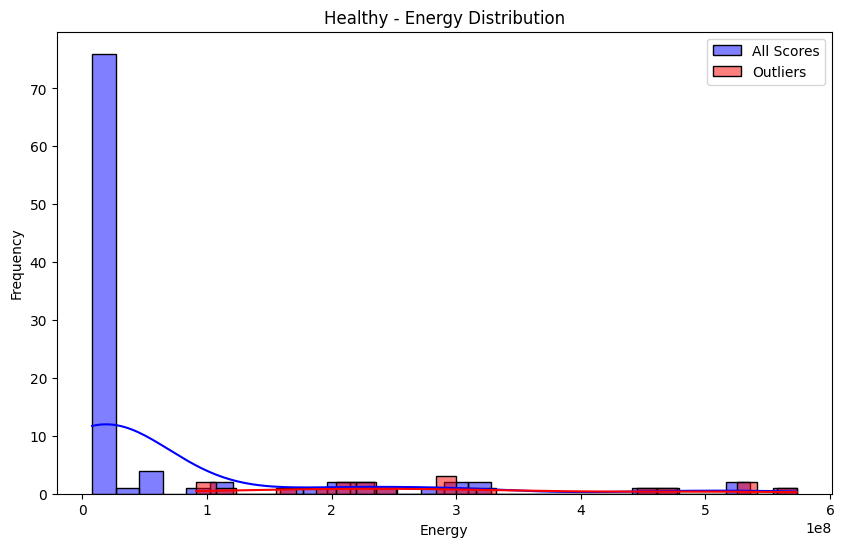

100%|███████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 179.75it/s]


Scurf - Skewness: 3.66
Scurf - Kurtosis: 15.92
Scurf - Number of outliers: 1
Scurf - Percentage of outliers: 1.72%


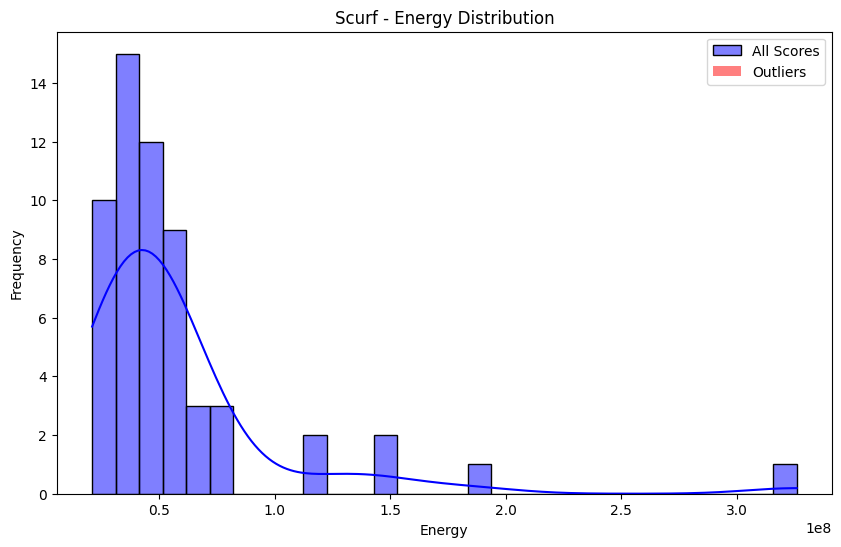

100%|███████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 295.06it/s]


Scab - Skewness: 3.04
Scab - Kurtosis: 9.66
Scab - Number of outliers: 1
Scab - Percentage of outliers: 1.61%


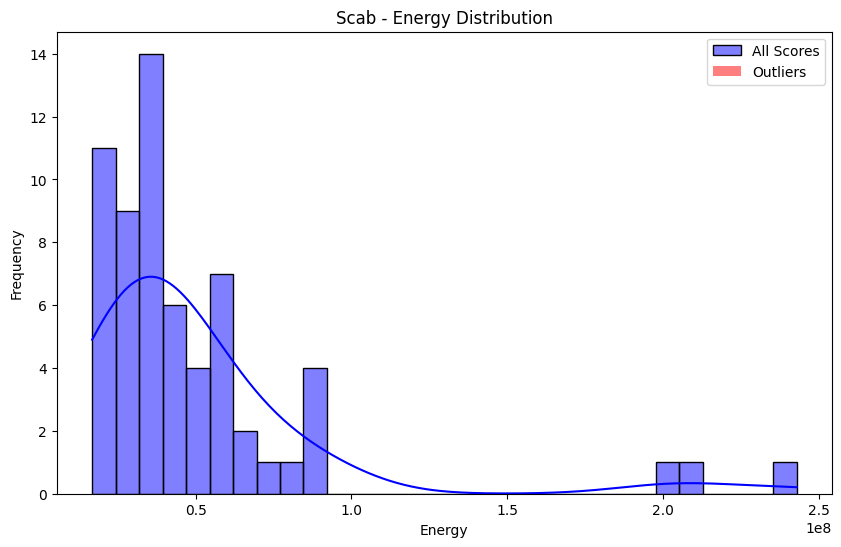

100%|████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.85it/s]


Beetle - Skewness: 2.10
Beetle - Kurtosis: 4.10
Beetle - Number of outliers: 1
Beetle - Percentage of outliers: 3.33%


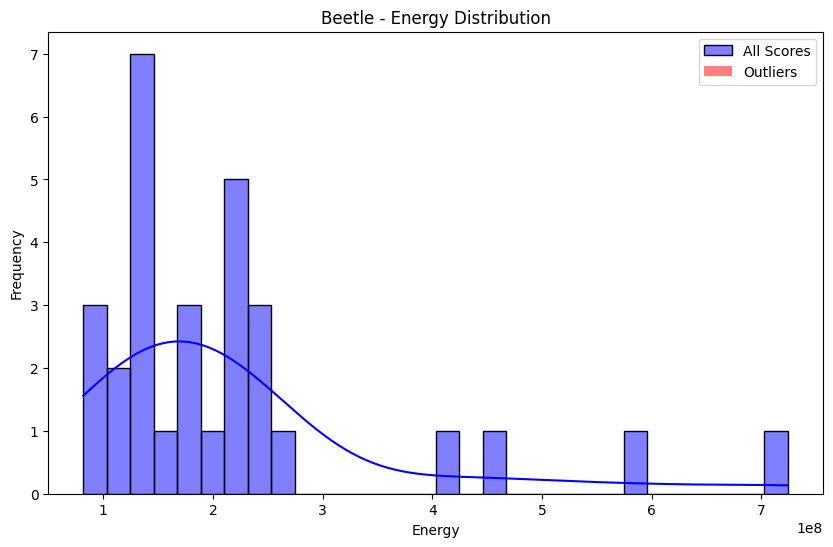

In [48]:
# Function to calculate the energy of an image
def calculate_image_energy(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    energy = np.sqrt(sobelx**2 + sobely**2).sum()
    return energy

# Function to check energy of images in a folder
def check_image_energy(folder):
    energy_scores = []
    for img_name in tqdm(os.listdir(folder)):
        img_path = os.path.join(folder, img_name)
        image = cv2.imread(img_path)
        if image is not None:
            energy = calculate_image_energy(image)
            energy_scores.append((img_name, energy))
    return energy_scores

# Function to detect outliers using adjusted MAD
def detect_outliers_mad(scores):
    scores_array = np.array([score[1] for score in scores])
    median = np.median(scores_array)
    mad = np.median(np.abs(scores_array - median))
    mad = mad if mad != 0 else 1e-6  # To prevent division by zero
    
    # Adjust threshold based on skewness and kurtosis
    skewness = skew(scores_array)
    kurt = kurtosis(scores_array)
    threshold = 3.5 + 0.5 * (np.abs(skewness) + np.abs(kurt))
    
    modified_z_scores = 0.6745 * (scores_array - median) / mad
    outliers = np.abs(modified_z_scores) > threshold
    return outliers

# Function to analyze distribution and plot energy scores
def analyze_and_plot_energy(energy_scores, outliers, category):
    scores = [score[1] for score in energy_scores]
    outlier_scores = [score[1] for i, score in enumerate(energy_scores) if outliers[i]]
    
    skewness = skew(scores)
    kurt = kurtosis(scores)
    
    print(f"{category} - Skewness: {skewness:.2f}")
    print(f"{category} - Kurtosis: {kurt:.2f}")
    print(f"{category} - Number of outliers: {len(outlier_scores)}")
    print(f"{category} - Percentage of outliers: {(len(outlier_scores) / len(scores)) * 100:.2f}%")
    
    plt.figure(figsize=(10, 6))
    sns.histplot(scores, bins=30, kde=True, color='blue', label='All Scores')
    sns.histplot(outlier_scores, bins=30, kde=True, color='red', label='Outliers')
    plt.title(f'{category} - Energy Distribution')
    plt.xlabel('Energy')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


# Define input folders for processing
folders = [
    ("potato_vino/healthy_crop/", "Healthy"),
    ("potato_vino/Black_scurf_fungus/", "Scurf"),
    ("potato_vino/Common_scab_bacteria/", "Scab"),
    ("potato_vino/Colorado_potato_beetle_insect/", "Beetle")
]

# Analyze images for each folder: check energy, detect outliers, and plot results
for input_dir, category in folders:
    energy_scores = check_image_energy(input_dir)
    outliers = detect_outliers_mad(energy_scores)
    analyze_and_plot_energy(energy_scores, outliers, category)


### Observation about energy of images
* Healthy images have a high number of outliers (19.80%), indicating significant variability in image energy. The distribution is positively skewed and has heavy tails.
* Scurf, Scab, and Beetle categories have lower percentages of outliers (1.72%, 1.61%, and 3.33%, respectively), suggesting more consistency in image energy. However, all three categories exhibit high skewness and kurtosis, indicating that their distributions are positively skewed with heavy tails, but with fewer extreme values compared to the Healthy category.

## Create new images with common augmentations to simulate natural variations.

In [60]:
import albumentations as A

# Function to augment images and count the number of augmented images added
def augment_images(input_dir, output_dir, augmentations, num_augmented_images=5):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    total_augmented_images = 0  # Counter for the number of augmented images added

    for img_name in tqdm(os.listdir(input_dir)):
        img_path = os.path.join(input_dir, img_name)
        image = cv2.imread(img_path)

        for i in range(num_augmented_images):
            augmented = augmentations(image=image)
            augmented_image = augmented['image']
            new_image_name = f"{os.path.splitext(img_name)[0]}_aug_{i}.jpg"
            cv2.imwrite(os.path.join(output_dir, new_image_name), augmented_image)
            total_augmented_images += 1  # Increment the counter

    print(f"Total number of images added in {output_dir}: {total_augmented_images}")
    return total_augmented_images

# Define augmentations
augmentations = A.Compose([
    A.Flip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Blur(blur_limit=3, p=0.5)
])


# Augment images in each folder
folders = [
    ("potato_vino/train/healthy_crop/", "potato_vino/train/healthy_crop_augmented/"),
    ("potato_vino/train/Black_scurf_fungus/", "potato_vino/train/Black_scurf_fungus_augmented/"),
    ("potato_vino/train/Common_scab_bacteria/", "potato_vino/train/Common_scab_bacteria_augmented/"),
    ("potato_vino/train/Colorado_potato_beetle_insect/", "potato_vino/train/Colorado_potato_beetle_insect_augmented/")
]

for input_dir, output_dir in folders:
    augment_images(input_dir, output_dir, augmentations)


100%|████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 44.00it/s]


Total number of images added in potato_vino/train/healthy_crop_augmented/: 400


100%|████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 62.05it/s]


Total number of images added in potato_vino/train/Black_scurf_fungus_augmented/: 230


100%|████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 60.53it/s]


Total number of images added in potato_vino/train/Common_scab_bacteria_augmented/: 245


100%|████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 27.99it/s]

Total number of images added in potato_vino/train/Colorado_potato_beetle_insect_augmented/: 120
